# Forecasting
Anytime when working with time-series data it is valuable to be able to precit future values and trends. This is especially true when working with financial data as these models will provide useful insight and can be incorporated into other strategies in a variety of useful ways.  

In this particular case we are looking to predict the price of Ethereum (in terms of Bitcoin) one data point into the future. If one of our algorithm trading codes has decided to buy Ethereum, we can incorporate our forecasting model and see if the future price will go up or down. If the model indicates the price will go down we can place our bid more conservatively (and do the same when selling). This will increase our margins a bit, which could prove to be useful in a high frequency traing (HFT) strategy.

## ARIMA
The autoregressive integrated moving average, otherwise known as ARIMA, is a well documented model that is used to analyze time-series data. In this case we will build our model, look into the different ways it can be used, and ultimately try to forecast Ethereum prices.  

It is worth noting that ARIMA is an old model. Currently more updated and well maintained models exist, such as SARIMAX, which is an ARIMA model with a seasonal trend in the data and the X is for exogenous variables which allow external variables to be considered in the model. I did try using SARIMAX to forecast with this data set, but found that seasonal component made forecasts less accurate. Normally the seasonal component value would be 31 for monthly trends, 12 for yearly data over the months, etc. and for price data with no clear trend I would make this variable 1 which ultimately appeared to detract from the model, so I switched back to ARIMA.

### Dependencies
There are a lot of them

In [1]:
import json
import os
import time
import csv
import sys
import math
import numpy as np
import pandas as pd
import statistics as st
import sklearn as sk
import scipy
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import multiprocessing as mp

### Data
First let's import the data set and plot it to get a sense of what we're working with

Text(0.5, 1.0, 'Ethereum Price Data')

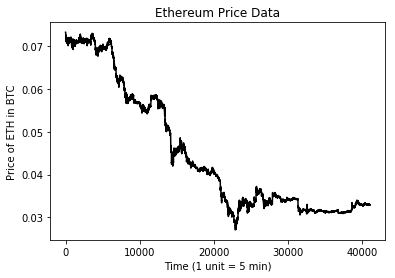

In [2]:
data = pd.read_csv('/Users/XXI/Desktop/Individual_Coins/BTC-ETH_Data_Crypto_2018_06_26.csv', header = 1)
lasts = data['lastPrice']
plt.plot(lasts, 'k')
plt.xlabel('Time (1 unit = 5 min)')
plt.ylabel('Price of ETH in BTC')
plt.title('Ethereum Price Data')

41k data points might become a bit time consuming to work with if we try to model and forecast the whole data set. It's also a really depressing chart to look at if you hold any ETH, so we can narrow our data set to 500 values somewhere in middle.  

Below we can see a smaller sample of data and the plot.

Sample of Price Data
20000    0.040418
20001    0.040300
20002    0.040330
20003    0.040327
20004    0.040207
Name: lastPrice, dtype: float64


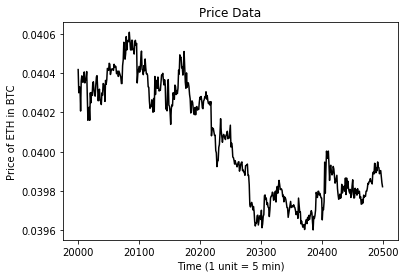

In [3]:
start = 20000
end = 20500
lasts.loc[start:end]
plt.plot(lasts.loc[start:end], 'k')
plt.xlabel('Time (1 unit = 5 min)')
plt.ylabel('Price of ETH in BTC')
plt.title('Price Data')

print('Sample of Price Data')
print(lasts.loc[start:end].head())

### Testing for Stationarity
The ARIMA model assumes we use stationary data. Stationary data's unconditional joint probability distribution does not change when shifted in time. This means that parameters such as mean and variance do not change over time. This is a basic assumption is many statistical models, especially time-series analysis.  

Therefore we must first test our data to see if it is stationary. We can do this by visually inspecting the raw data plot, histogram, autocorrelation function, and partial correlation function. The data is clearly down trending and the histogram is not a normal distribution. Among the autocorrelation plots there is no clear lag order indicating a prices correlation with a n delayed past value. Our data is most likely not stationary.

/Users/XXI/miniconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


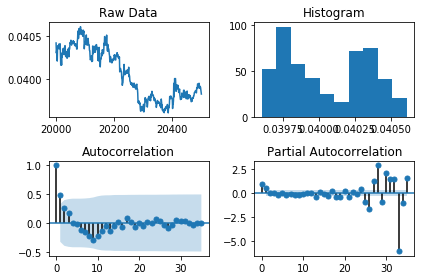

In [4]:
figure, stationary = plt.subplots(2, 2)
plt_lasts = lasts.loc[start:start+35]
smt.graphics.plot_acf(plt_lasts, ax=stationary[1, 0])
smt.graphics.plot_pacf(plt_lasts, ax=stationary[1, 1])
stationary[0, 0].plot(lasts.loc[start:end])
stationary[0, 0].set_title('Raw Data')
stationary[0, 1].hist(lasts.loc[start:end], bins='auto')
stationary[0, 1].set_title('Histogram')
plt.tight_layout()

### Augmented Dickey-Fuller Test
To be sure of this we can use the Augmented Dickey-Fuller (ADF) test to check. The null hypothesis is that our data is stationary and if we obtain a p-value of less than 0.05 we can reject the null hypothesis suggesting that our data is indeed stationary. As seen below from the results of the test the p-value is 0.58 indicating the data is **not** stationary.

In [5]:
adfTest = statsmodels.tsa.stattools.adfuller(lasts.loc[start:end])
print('ADF Statistic: %f' % adfTest[0])
print('p-value: %f' % adfTest[1])
print('Critical Values:')
for key, value in adfTest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.398654
p-value: 0.582921
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


### Transforming the Data to Achieve Stationarity
There are two primary methods we can use to transform the data. We can take the logarithm of all the values. This is highly effective when working with exponential data. It can also be used when working with panel data where the values of one column are much larger than those of another, so taking the log scales the values down as to minimize effects caused by large magnitude differences. In this case this method is not appropriate.  

Instead we can difference the data. This means we take p(t) - p(t-1) for all t, thus leaving us with the values of the change from one point to another. Differencing this data set is likely to make it stationary.  

A sample of the differenced data is shown below. Our first plot ressembles white noise, which by definition is stationary. This is a good sign and the histogram is normally distributed now. Once again there is no clear lag order indicating a correlation between data points of any n distance apart, but this is not an issue.

Sample of Differenced Price Data
20000    0.000001
20001   -0.000118
20002    0.000030
20003   -0.000003
20004   -0.000120
Name: lastPrice, dtype: float64


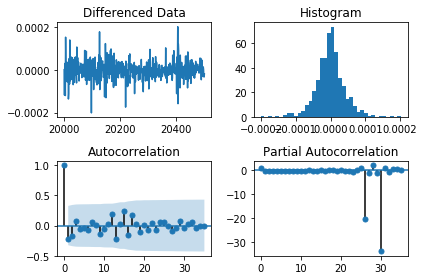

In [6]:
differenced = lasts.diff()
plt_diffs = differenced.loc[start:start+35]
figure, stationary = plt.subplots(2, 2)
plt_lasts = lasts.loc[start:start+35]
smt.graphics.plot_acf(plt_diffs, ax=stationary[1, 0])
smt.graphics.plot_pacf(plt_diffs, ax=stationary[1, 1])
stationary[0, 0].plot(differenced.loc[start:end])
stationary[0, 0].set_title('Differenced Data')
stationary[0, 1].hist(differenced.loc[start:end], bins='auto')
stationary[0, 1].set_title('Histogram')
plt.tight_layout()

print('Sample of Differenced Price Data')
print(differenced.loc[start:end].head())

To be certain our data is stationary we can once again test it with the ADF, which reveals a p-value < 1e-6. We can now use this stationary data for our model and forecasting.

In [7]:
adfTest = statsmodels.tsa.stattools.adfuller(differenced.loc[start:end])
print('ADF Statistic: %f' % adfTest[0])
print('p-value: %f' % adfTest[1])
print('Critical Values:')
for key, value in adfTest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.200952
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


### The ARIMA Model
The model take 3 inputs known as p, d, and q. They represent the order of lags of autoregressive model, the number of times the data is differenced, and the order of the moving-average model repsectively.

Below the ARIMA model is used on the raw data with d=1 and of the differenced data with d=0. P and q are the both 1 in the two models. Notice how they give the exact same results.

In [8]:
window = lasts.loc[start-1:start+49] # need to input 1 extra data point because you lose one when differencing
model = ARIMA(window, order=(1,1,1))
model_fit = model.fit()
print('Raw Data Differenced in the Model d=1:')
print(model_fit.summary())

window = differenced.loc[start:start+49]
model = ARIMA(window, order=(1,0,1))
model_fit = model.fit()
print('\n\nDifferenced Data with Model d=0:')
print(model_fit.summary())

Raw Data Differenced in the Model d=1:
                             ARIMA Model Results                              
Dep. Variable:            D.lastPrice   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 418.890
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 19 Nov 2018   AIC                           -829.779
Time:                        13:55:59   BIC                           -822.131
Sample:                             1   HQIC                          -826.867
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.663e-09   1.97e-06     -0.002      0.999   -3.86e-06    3.86e-06
ar.L1.D.lastPrice     0.5089        nan        nan        nan         n

/Users/XXI/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/XXI/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/XXI/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/XXI/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)




Differenced Data with Model d=0:
                              ARMA Model Results                              
Dep. Variable:              lastPrice   No. Observations:                   50
Model:                     ARMA(1, 1)   Log Likelihood                 418.890
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 19 Nov 2018   AIC                           -829.779
Time:                        13:56:00   BIC                           -822.131
Sample:                             0   HQIC                          -826.867
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.663e-09   1.97e-06     -0.002      0.999   -3.86e-06    3.86e-06
ar.L1.lastPrice     0.5089        nan        nan        nan         nan         n

### Predicting Future Values
Now we can take our model and use it to predict some prices. In this case, we'll try to predict 5 data points into the future. Since we make our prediction off of the differenced data we need to we need to add back the value of the most recent price in order to adjust the values back to something recognizable as seen in the second plot.  

Even before quantitatively assessing the error, we can visually see that the predictions are not great.

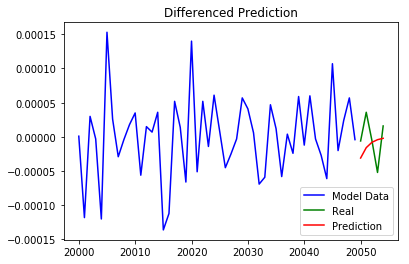

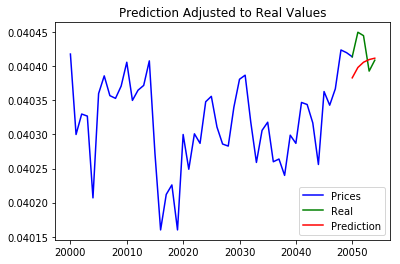

In [9]:
future_values = 5
x_axis = np.arange(20050, 20050+future_values)
output = model_fit.forecast(future_values)
prediction = output[0]
predictions = []
for i in range(0, future_values):
    predictions.append(prediction[i])

plt.figure()
plt.plot(window, 'b')
plt.plot(differenced.loc[20050:20054], 'g')
plt.plot(x_axis, predictions, 'r')
plt.title('Differenced Prediction')
plt.legend(['Model Data', 'Real', 'Prediction'])

plt.figure()
plt.plot(lasts.loc[start:20050], 'b')
plt.plot(lasts.loc[20050:20054], 'g')
plt.plot(x_axis, predictions + lasts.loc[20050], 'r')
plt.title('Prediction Adjusted to Real Values')
plt.legend(['Prices', 'Real', 'Prediction'])

### Rolling Window
Predicting several points into the future is a bit harder to do and ultimately not the objective here. Instead we can employ a rolling window. This means that we take a window of 50 data points and predict the 51st. Then we look at data points 2 to 51 and and predict the 52nd, so on and so forth. Using this method we can always use the 50 most recent data points to forecast one ahead, which will hopefully yield better results and be more akin to the way the model might be implemented alongisde a trading strategy. The choice of 50 is somewhat arbitrary, but 5 would be too small and 100 will add to computation time without offering significantly better results. The window size itself can be made a parameter to optimize in the grid search functions below, but for simplicity we will omit it this time.

Below the errors measured in 3 different ways are all found to be quite small and our predictions seem to have improved!

Sum of The Squared Errors: 0.0000000665
Root Mean Square Error: 0.0039917156
Errors as Percentage: 0.0199815525%


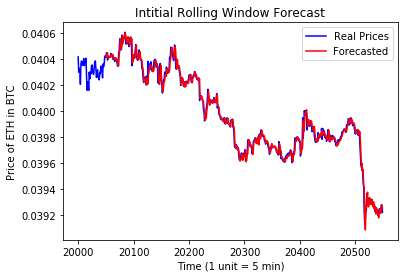

In [10]:
import warnings
warnings.filterwarnings('ignore')

SSE = 0
RMSE = 0
Error = 0

predictions = []
futurePts = 500
for i in range(0, futurePts):
    window = lasts.loc[start+i-1:start+i+49]
    model = ARIMA(window, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(1)
    prediction = output[0]
    predictions.append(prediction)
    SSE_new = (prediction - lasts.loc[start+i+49])**2
    SSE += SSE_new
    RMSE += np.sqrt(SSE_new)
    Error += abs((prediction - lasts.loc[start+i+49])/lasts.loc[start+i+49])

x_axis = np.arange(20050, 20050+futurePts)
plt.plot(lasts.loc[20000:20049+futurePts], 'b')
plt.plot(x_axis, predictions, 'r')
plt.xlabel('Time (1 unit = 5 min)')
plt.ylabel('Price of ETH in BTC')
plt.title('Intitial Rolling Window Forecast')
plt.legend(['Real Prices', 'Forecasted'])

print('Sum of The Squared Errors: {0:.10f}'.format(float(SSE)))
print('Root Mean Square Error: {0:.10f}'.format(float(RMSE)))
print('Errors as Percentage: {0:.10f}%'.format(float(Error*100/futurePts)))

### Grid Search
In the model so far I have been arbitrarily picking p, d, and q values. If we want to improve our model accuracy more scientifically we can use grid search. This is method where combinations of parameters are brute forced and scored with an evaluation model. The results can then be used to select the best model to be used. While there is a predefined grid search function in scikit-learn it is very easy to write our own from scratch.  

First we wrap up the rolling window model above into a function taking p, d, and q as inputs. A second function which is the grid search defines several parameter combinations and sequentially tests them with our ARIMA model evaluating them on the percent error.

In [11]:
def ARIMA_Model(p, d, q, lasts):
    SSE_ = 0
    RMSE_ = 0
    Error_ = 0
    
    if(d == 0):
        extraPt = 0
    else:
        extraPt = 1
        
    predictions = []
    futurePts = 500
    for i in range(0, futurePts):
        window = lasts.loc[start+i-extraPt:start+i+49]
        try:
            model = ARIMA(window, order=(p, d, q))
            model_fit = model.fit()
        except:
            continue
        output = model_fit.forecast(1)
        prediction = output[0]
        predictions.append(prediction)
        SSE_new = (prediction - lasts.loc[start+i+49])**2
        SSE_ += SSE_new
        RMSE_ += np.sqrt(SSE_new)
        Error_ += abs((prediction - lasts.loc[start+i+49])/lasts.loc[start+i+49])

    return SSE_, RMSE_, Error_


def ARIMA_GridSearch(lasts):
    testParameters = [[0, 0, 0], # these are manually hard coded, but it is easy to
                      [1, 0, 0], # make a version where these are randomized or
                      [1, 1, 0], # generated by inputs
                      [2, 0, 0],
                      [2, 1, 0],
                      [2, 1, 1],
                      [3, 0, 0],
                      [3, 1, 0],
                      [3, 1, 1]]
    
    headers = ['p', 'd', 'q', 'SSE', 'RMSE', 'Error Percentage']
    results = pd.DataFrame(np.zeros((len(testParameters), len(headers))), columns=headers)
    for i in range(0, len(testParameters)):
        pdq = testParameters[i]
#         print(pdq)
        SSE, RMSE, Error = ARIMA_Model(pdq[0], pdq[1], pdq[2], lasts)
        results.loc[i, :] = [pdq[0], pdq[1], pdq[2], SSE, RMSE, Error/500]

    return results
    
GridSearchResults = ARIMA_GridSearch(lasts)
print('Grid Search Results:')
print(GridSearchResults.sort_values('Error Percentage'))

Grid Search Results:
     p    d    q           SSE      RMSE  Error Percentage
2  1.0  1.0  0.0  6.646505e-08  0.003992          0.000200
4  2.0  1.0  0.0  8.829676e-08  0.004491          0.000225
5  2.0  1.0  1.0  9.819852e-08  0.004619          0.000231
7  3.0  1.0  0.0  1.178140e-07  0.005029          0.000252
8  3.0  1.0  1.0  1.290789e-07  0.005242          0.000262
1  1.0  0.0  0.0  1.013209e-07  0.005340          0.000267
3  2.0  0.0  0.0  1.175522e-07  0.005499          0.000275
6  3.0  0.0  0.0  1.461057e-07  0.005904          0.000295
0  0.0  0.0  0.0  1.045535e-05  0.053138          0.002668


### Multiprocessing
The above grid search takes about 15 minutes to run. We can trade more processing power for a faster runtime by using multiprocessing. The previous functions are copy/pasted below and then slightly tweaked, so that each parameter combination can be tested in parallel with it's own process.

The model with the smallest error has inputs (1,1,0) which means the autoregrissve order is 1, the data was differenced once and the moving average component wasn't used. ARIMA(1,1,0) = ARI(1,1) so this is simply a differenced autoregressive model.

Note: This kind of a test is CPU bound, so multithreading will not be advantageous and will likely be slower than the sequentially tested grid search model above.

In [12]:
def ARIMA_Model_MP(p, d, q, lasts, counter, ind_output):
    SSE_ = 0
    RMSE_ = 0
    Error_ = 0
    
    if(d == 0):
        extraPt = 0
    else:
        extraPt = 1

    predictions = []
    futurePts = 500
    for i in range(0, futurePts):
        window = lasts.loc[start+i-extraPt:start+i+49]
        try:
            model = ARIMA(window, order=(p, d, q))
            model_fit = model.fit()
        except:
            continue
        output = model_fit.forecast(1)
        prediction = output[0]
        predictions.append(prediction)
        SSE_new = (prediction - lasts.loc[start+i+49])**2
        SSE_ += SSE_new
        RMSE_ += np.sqrt(SSE_new)
        Error_ += abs((prediction - lasts.loc[start+i+49])/lasts.loc[start+i+49])
    
    final = [counter, p, d, q, SSE_, RMSE_, Error_/500]
    ind_output.put(final)
    return [counter, p, d, q, SSE_, RMSE_, Error_/500]

def ARIMA_GridSearch_MP(lasts):
    testParameters = [[0, 0, 0], 
                      [1, 0, 0],
                      [1, 1, 0],
                      [2, 0, 0],
                      [2, 1, 0],
                      [2, 1, 1],
                      [3, 0, 0],
                      [3, 1, 0],
                      [3, 1, 1]]
    
    headers = ['p', 'd', 'q', 'SSE', 'RMSE', 'Error Percentage']
    results = pd.DataFrame(np.zeros((len(testParameters), len(headers))), columns=headers)
    
    counter = 0
    output = mp.Queue()
    jobs = []
    for i in range(0, len(testParameters)):
        pdq = testParameters[i]
        task = mp.Process(target=ARIMA_Model_MP, args=(pdq[0], pdq[1], pdq[2], lasts, counter, output))
        jobs.append(task)

        counter += 1

    for task in jobs:
        task.start()

    for task in jobs:
        task.join()

    ind_result = [output.get() for task in jobs]
    ind_result.sort()
    ind_result = np.array(ind_result)
    ind_result = ind_result[:, 1:]
    
    results.loc[:, :] = ind_result[:, :]

    return results
    
GridSearchResults = ARIMA_GridSearch_MP(lasts)
print('Grid Search Results:')
print(GridSearchResults.sort_values('Error Percentage'))

Grid Search Results:
     p    d    q           SSE      RMSE  Error Percentage
2  1.0  1.0  0.0  6.646505e-08  0.003992          0.000200
4  2.0  1.0  0.0  8.829676e-08  0.004491          0.000225
5  2.0  1.0  1.0  9.819852e-08  0.004619          0.000231
7  3.0  1.0  0.0  1.178140e-07  0.005029          0.000252
8  3.0  1.0  1.0  1.290789e-07  0.005242          0.000262
1  1.0  0.0  0.0  1.013209e-07  0.005340          0.000267
3  2.0  0.0  0.0  1.175522e-07  0.005499          0.000275
6  3.0  0.0  0.0  1.461057e-07  0.005904          0.000295
0  0.0  0.0  0.0  1.045535e-05  0.053138          0.002668


### Optimized ARIMA Rolling Window Forecast
Now using the optimized ARIMA(1,1,0) we can try visualizing our rolling window forecast.

Sum of The Squared Errors: 0.0000000665
Root Mean Square Error: 0.0039917156
Errors as Percentage: 0.0199815525%


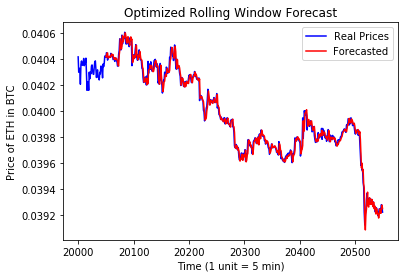

In [13]:
SSE = 0
RMSE = 0
Error = 0

predictions = []
futurePts = 500
for i in range(0, futurePts):
#     print(i)
    window = lasts.loc[start+i-1:start+i+49]
    try:
        model = ARIMA(window, order=(1,1,0))
        model_fit = model.fit()
    except:
        continue
    output = model_fit.forecast(1)
    prediction = output[0]
    predictions.append(prediction[0])
    SSE_new = (prediction - lasts.loc[start+i+49])**2
    SSE += SSE_new
    RMSE += np.sqrt(SSE_new)
    Error += abs((prediction - lasts.loc[start+i+49])/lasts.loc[start+i+49])

x_axis = np.arange(20050, 20050+futurePts)
plt.plot(lasts.loc[20000:20049+futurePts], 'b')
plt.plot(x_axis, predictions, 'r')
plt.xlabel('Time (1 unit = 5 min)')
plt.ylabel('Price of ETH in BTC')
plt.title('Optimized Rolling Window Forecast')
plt.legend(['Real Prices', 'Forecasted'])

print('Sum of The Squared Errors: {0:.10f}'.format(float(SSE)))
print('Root Mean Square Error: {0:.10f}'.format(float(RMSE)))
print('Errors as Percentage: {0:.10f}%'.format(float(Error*100/futurePts)))

### In Depth Look
It now seems as if the model is ready and suitable to be used for real applications, but let's just take a closer look first...  

Upon closer investigation the results are slightly off. In fact, if we left shift the forecasts by 1 we find that they're a perfect match! This means that the best model "_predicts_" p(t+1) = p(t). Because our time step is sufficiently small (5 minutes) the prices do not move a lot from one data point to the next. Therefore weighting the most recent value more heavily to predict the next leads to seemingly good forecasts which yield impressively low errors. However, this is hardly real predicting, let alone a useful model.

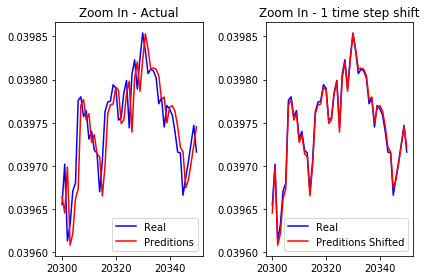

In [14]:
figure, zooms = plt.subplots(1, 2)
zooms[0].plot(lasts.loc[20300:20350], 'b')
zooms[0].plot(np.arange(20300, 20351), predictions[250:301], 'r')
zooms[0].set_title('Zoom In - Actual')
zooms[0].legend(['Real', 'Preditions'])

zooms[1].plot(lasts.loc[20300:20350], 'b')
zooms[1].plot(np.arange(20300, 20351), predictions[251:302], 'r')
zooms[1].set_title('Zoom In - 1 time step shift')
zooms[1].legend(['Real', 'Preditions Shifted'])
plt.tight_layout()

### Correlation
Another way to view this is by taking the Pearson Correlation Coefficient of the actual prices and predictions. When viewed this way it is clear that the shifted prediction data is highly correlated with the actual prices. That being said the r correlation value of the actual predictions is still quite high, but this can be attributed to the fact that the time step is so small that any difference between one data point and the next is minimal. As our time step increases to look at hourly, daily, or monthly data we would find a significant drop in correlation, while shifted correlation would remain close to 1.

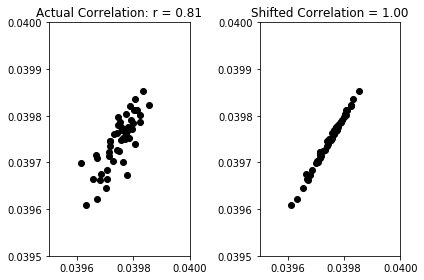

In [15]:
fig, confirmed = plt.subplots(1, 2)
actual_corr = np.vstack((np.array(lasts.loc[20050:20549]), predictions))
corr = np.corrcoef(lasts.loc[20300:20350], predictions[250:301])
confirmed[0].scatter(np.array(lasts.loc[20300:20350]), predictions[250:301], color='k')
confirmed[0].set_title('Actual Correlation: r = {:.2f}'.format(corr[0, 1]))
confirmed[0].axis([0.0395,0.04,0.0395,0.04])

shifted_corr = np.vstack((np.array(lasts.loc[20300:20350]), predictions[251:302]))
corr = np.corrcoef(shifted_corr)
confirmed[1].scatter(np.array(lasts.loc[20300:20350]), predictions[251:302], color='k')
confirmed[1].set_title('Shifted Correlation = {:.2f}'.format(corr[0, 1]))
confirmed[1].axis([0.0395,0.04,0.0395,0.04])
plt.tight_layout()

### Conclusion
This ARIMA model is not useful for actual price forecasting. One might venture to say that another model might prove to be better, but we don't have to check that ourselves. Rafael Schultze-Kraft's [article](https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151) beat me to the punch using a long-short term memory recurring neural network (LSTM RNN) to find the same results and draw the same conclusion. This is not to say the ARIMA model in general is not powerful; for different data sets it can be a marvelous tool [see here](https://github.com/santhoshetty/Liquor-Sales-Forecast/blob/master/Liquor%20Sales%20Forecast.ipynb). In the end it is valuable to incorporate more data into the model, perhaps adding volume, orderbook data, and trade data. Once adding these features and further fine tuning the model it may be possible to obtain usable price predictions.  

Another possibility is to simplify the model itself. ARIMA seeks to predict a specific value and for my particular use case I only care to find whether the next data point is higher or lower than the current one. In this regard the optimizing the model to minimize prediction error doesn't help as it may predict a price close to, but lower than the actual value in a scenario where the price moved up. If we measure this we will find the model is conssitently predicting the wrong direction of the price movement and at best is 50%/50%. We can adapt the model to predict a binary outcome: the price will go up or down. This will greatly simplify things and while we lose specific data point values we can hopefully obtain a model that's overall prediction rate is better that haphazard guessing.